In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
import gc
from tqdm import tqdm

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/ML-project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def merge_all_data_frames(daily_data, firm_characteristics, jkp_factors, linking_table):
    """
    Merges daily returns, firm characteristics, and JKP factor returns into a single unified DataFrame.

    This function:
    - Merges firm-level characteristics (typically quarterly) with a CRSP-Compustat linking table (indexed by 'gvkey')
      that provides PERMNO and PERMCO mappings.
    - Filters the linking table for valid link types and date ranges.
    - Uses `merge_asof` to forward-fill quarterly firm characteristics to match daily frequency.
    - Merges in JKP factor returns (wide format, indexed by month-end 'date' and with one column per factor).
    - Drops temporary or redundant merge columns and sets the final index for analysis.

    Parameters:
    ----------
    daily_data : pd.DataFrame
        DataFrame of daily stock return data. Must contain columns: ['date', 'PERMNO', 'PERMCO'].

    firm_characteristics : pd.DataFrame
        DataFrame of firm-level characteristics at quarterly frequency.
        Must be indexed by ['date', 'gvkey'].

    jkp_factors : pd.DataFrame
        DataFrame of JKP factor returns in wide format, indexed by month-end dates.
        Each column corresponds to a different factor name, and values are the respective returns.

    linking_table : pd.DataFrame
        Compustat-CRSP linking table indexed by 'gvkey'. Must contain columns: ['PERMNO', 'PERMCO', 'LINKTYPE', 'LINKDT', 'LINKENDDT'].

    Returns:
    -------
    pd.DataFrame
        A merged DataFrame indexed by ['date', 'PERMCO', 'PERMNO'], containing:
        - daily returns,
        - forward-filled firm characteristics (from quarterly),
        - monthly JKP factor returns (aligned to the daily data by month-end).
    """

    # Reset indexes for merging
    firm_characteristics = firm_characteristics.reset_index()
    linking_table = linking_table.reset_index()

    # Merge firm characteristics with linking table
    comp_linked = pd.merge(firm_characteristics, linking_table, how='left', on='gvkey')

    # Filter for valid link types and valid link dates
    comp_linked = comp_linked[comp_linked['LINKTYPE'].isin(['LU', 'LC'])]
    comp_linked = comp_linked[
        (comp_linked['date'] >= comp_linked['LINKDT']) &
        (comp_linked['date'] <= comp_linked['LINKENDDT'])
    ]

    # Drop PERMCO from comp_linked to avoid duplication
    comp_linked = comp_linked.drop(columns=['PERMCO'], errors='ignore')

    # Rename for clarity and compatibility
    comp_linked.rename(columns={'date': 'quarter_date'}, inplace=True)
    comp_linked['PERMNO'] = comp_linked['PERMNO'].astype('int64')

    # Reset index on daily_data for merge_asof
    daily_data = daily_data.reset_index()

    # Merge using merge_asof to align firm characteristics to most recent available quarter
    merged = pd.merge_asof(
        daily_data.sort_values('date'),
        comp_linked.sort_values('quarter_date'),
        by='PERMNO',
        left_on='date',
        right_on='quarter_date',
        direction='backward'
    )
    # Create month-end column to align with JKP factor data
    merged['month_end'] = merged['date'] + pd.offsets.MonthEnd(0)

    if jkp_factors is not None:
        print("Start joining JKP factors")
        # Reset index on jkp_factors to merge
        jkp_factors = jkp_factors.reset_index()

        # Merge JKP factors by month-end date
        merged = pd.merge(merged, jkp_factors, how='left', left_on='month_end', right_on='date')
        print("Finished second merge")

    # Drop redundant or intermediary columns
    merged.drop(columns=[
        'quarter_date', 'month_end', 'LINKDT', 'LINKENDDT', 'LINKTYPE',
        'gvkey', 'date_y'
    ], inplace=True, errors='ignore')

    # Rename date_x back to date for clarity
    merged.rename(columns={'date_x': 'date'}, inplace=True)

    # Set final index as required
    merged.set_index(['date', 'PERMCO', 'PERMNO'], inplace=True)

    return merged

In [4]:
firmchar = pd.read_csv(folder + "/Predictors/CompFirmCharac_sanitized.csv", parse_dates = True)
firmchar['date'] = pd.to_datetime(firmchar['date'], format = "%Y-%m-%d")

#goodcolumns = firmchar.columns[(firmchar.isna().sum() / len(firmchar)) < 0.3]
#firmchar = firmchar[goodcolumns]

firmchar.head(2)

,date,gvkey,acchgy,aolochy,aqcy,capxy,chechy,cibegniy,cicurry,cidergly,...,txbcoy,txdcy,txty,txwy,xidocy,xidoy,xinty,xiy,xopry,xsgay
0,2000-01-31,1013,0.0,-4.824,17.963,46.785,21.138,NaN,NaN,NaN,...,NaN,NaN,15.30,NaN,0.000,0.000,NaN,0.0,496.900,205.600
1,2000-01-31,1082,0.0,-1.734,0.000,9.597,-2.956,NaN,NaN,NaN,...,NaN,1.061,0.59,NaN,2.975,-2.563,4.084,0.0,123.541,6.468


<ipython-input-5-e59557439491>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  na_frac = firmchar.groupby('date').apply(lambda x: x.isna().sum() / len(x))
<ipython-input-5-e59557439491>:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


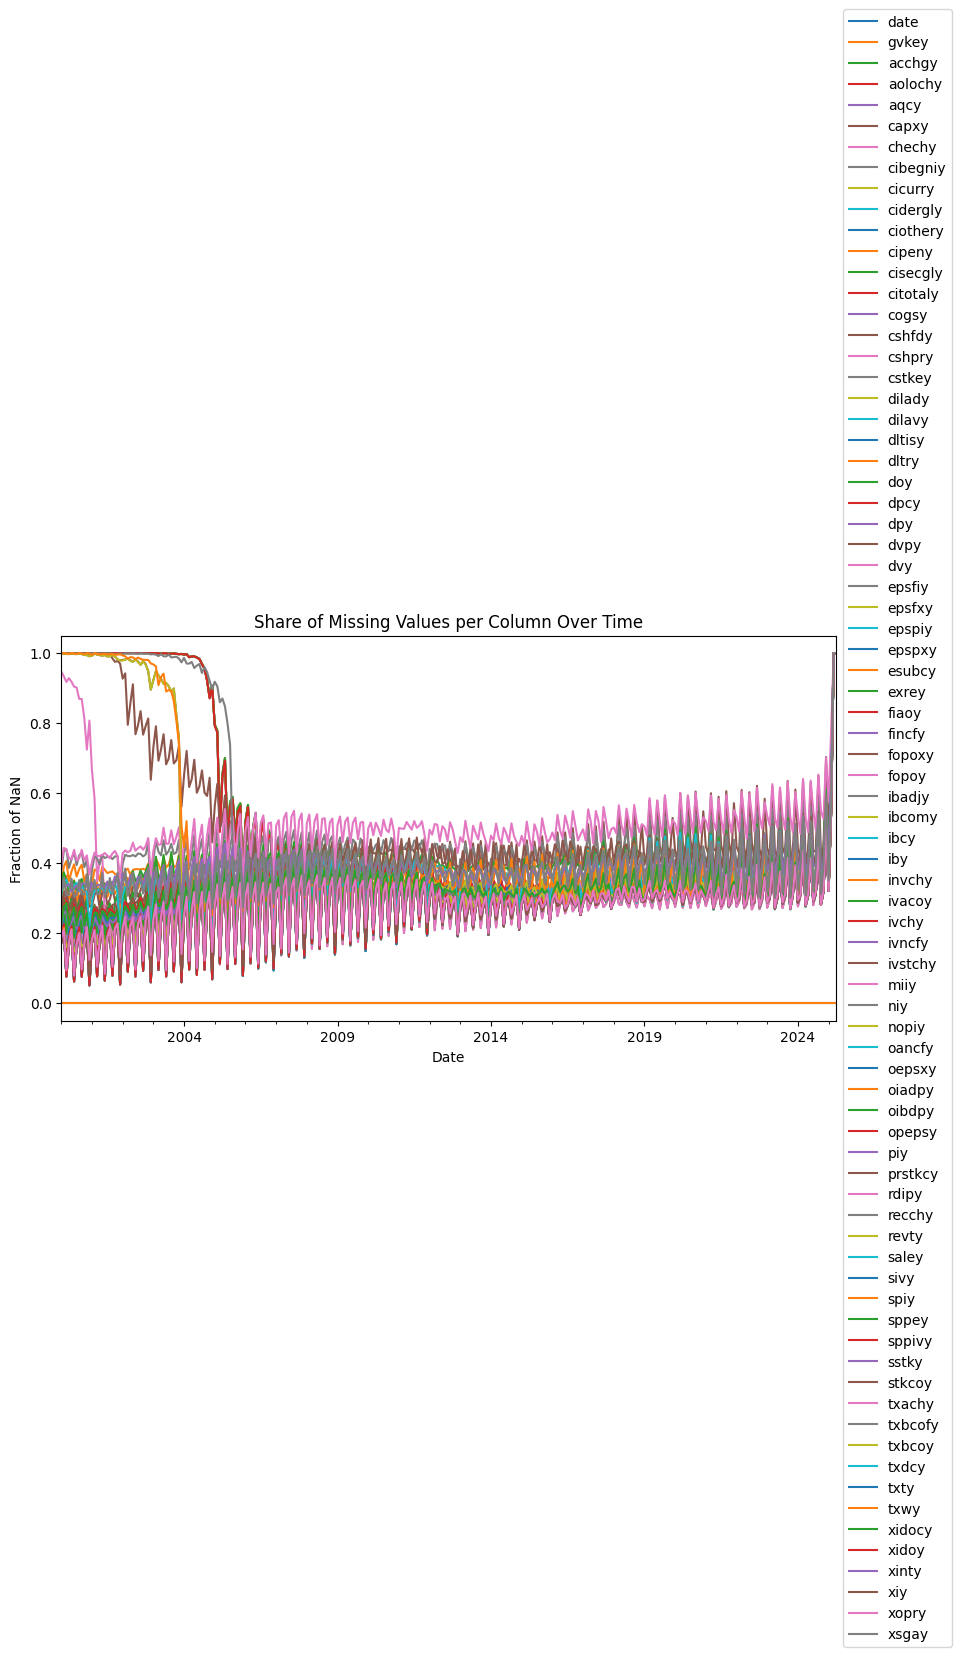

In [5]:
# Calculate fraction of NaNs per column for each date
na_frac = firmchar.groupby('date').apply(lambda x: x.isna().sum() / len(x))
na_frac = na_frac.sort_index()

ax = na_frac.plot(figsize=(10, 5))
ax.set_xlabel('Date')
ax.set_ylabel('Fraction of NaN')
ax.set_title('Share of Missing Values per Column Over Time')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


In [6]:
dailyret = pd.read_csv(folder + "/Targets/daily_crsp_sanitized.csv")
dailyret['date'] = pd.to_datetime(dailyret['date'], format = "%Y-%m-%d")
dailyret = dailyret[dailyret['date'] >= '2000-01-31']
dailyret.head(2)

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218


In [7]:
linking = pd.read_csv(folder + "/linking_table_sanitized.csv")
linking['LINKDT'] = pd.to_datetime(linking['LINKDT'], format = "%Y-%m-%d")
linking['LINKENDDT'] = pd.to_datetime(linking['LINKENDDT'], format = "%Y-%m-%d")
linking.head(2)

,gvkey,LINKTYPE,PERMNO,PERMCO,LINKDT,LINKENDDT
0,1000,LU,25881,23369,1970-11-13,1978-06-30
1,1001,LU,10015,6398,1983-09-20,1986-07-31


In [8]:
fgv = firmchar.gvkey.unique()
lgv = linking.gvkey.unique()
print(f"There are {len(fgv)} unique gvkey values in firm characteristics dataset, \n with {len(lgv)} unique in linking table, and only {len(set(lgv) & set(fgv))} in intersection of these two")

There are 32455 unique gvkey values in firm characteristics dataset, 
 with 28809 unique in linking table, and only 17589 in intersection of these two


### We build our first simple benchmark

In [9]:
def slice_dataframes(dailyret: pd.DataFrame, firmchar: pd.DataFrame, min_date: str, max_date: str, is_training: bool = True) -> tuple:
    """
    Slices two dataframes based on a date range.

    Args:
        dailyret (pd.DataFrame): DataFrame with daily data and 'date' column.
        firmchar (pd.DataFrame): DataFrame with monthly data and 'date' column.
        min_date (str): Start date for slicing (inclusive).
        max_date (str): End date for slicing (inclusive for training, inclusive for testing).
        is_training (bool): Flag to indicate if slicing is for training (True) or testing (False).

    Returns:
        tuple: Sliced dailyret and firmchar DataFrames.
    """
    if is_training:
        # For training: include both min_date and max_date
        dailyret_sliced = dailyret[(dailyret['date'] >= min_date) & (dailyret['date'] <= max_date)].copy()
        firmchar_sliced = firmchar[(firmchar['date'] >= min_date) & (firmchar['date'] <= max_date)].copy()
    else:
        # For testing: start forecasting for the next day after training, BUT we assume that we know the latest update of the factors as of EoM
        dailyret_sliced = dailyret[(dailyret['date'] > min_date) & (dailyret['date'] < max_date)].copy()
        firmchar_sliced = firmchar[(firmchar['date'] >= min_date) & (firmchar['date'] < max_date)].copy()
    return dailyret_sliced, firmchar_sliced

def process_dataframe(df: pd.DataFrame, nan_threshold: float = 0.3) -> tuple:
    """
    Processes a DataFrame by dropping columns with high NaN percentage and filling NaNs with cross-sectional means.

    Args:
        df (pd.DataFrame): Input DataFrame.
        nan_threshold (float): Threshold for dropping columns based on NaN percentage (default: 0.3).

    Returns:
        tuple: Processed DataFrame and dictionary of cross-sectional means.
    """
    # Calculate NaN percentage per column
    nan_pct = df.isna().mean()
    cols_to_drop = nan_pct[nan_pct > nan_threshold].index
    df_processed = df.drop(columns=cols_to_drop)

    # Calculate cross-sectional means (excluding 'date', 'gvkey', 'DlyRet')
    exclude_cols = ['date', 'gvkey', 'DlyRet', 'PERMCO',  'PERMNO',  'SICCD', 'NAICS']
    feature_cols = [col for col in df_processed.columns if col not in exclude_cols]
    cs_means = df_processed[feature_cols].mean()

    # Fill NaNs with cross-sectional means
    for col in feature_cols:
        df_processed[col] = df_processed[col].fillna(cs_means[col])

    return df_processed, cs_means, cols_to_drop

In [10]:
def train_model(train_df: pd.DataFrame) -> LinearRegression:
    """
    Trains a Linear Regression model on the processed DataFrame.

    Args:
        train_df (pd.DataFrame): Processed DataFrame with 'DlyRet' as target.

    Returns:
        LinearRegression: Trained model.
        final_feature_columns: final columns used in the training
    """
    feature_cols = [col for col in train_df.columns if col not in ['date', 'gvkey', 'DlyRet', 'PERMCO',
                                                                   'PERMNO',  'SICCD', 'NAICS' ]]
    X = train_df[feature_cols]
    y = train_df['DlyRet']
    model = LinearRegression()
    model.fit(X, y)
    return model, feature_cols

def normalize_weights(predictions: pd.Series) -> pd.Series:
    """
    Applies threshold to predictions and normalizes them to sum to 1 within each date.

    Args:
        predictions (pd.Series): Predicted returns with 'date' and 'PERMCO' and 'PERMNO' in index.

    Returns:
        pd.Series: Normalized weights.
    """

    # Normalize within each date
    weights = predictions.groupby('date')[['prediction']].transform(lambda x: x / x.sum() if x.sum() != 0 else 0)
    return weights

In [11]:
def portfolio_returns(dailyret: pd.DataFrame, firmchar: pd.DataFrame, window: int,
                      ) -> tuple:
    """
    Computes portfolio returns using a rolling window strategy with Linear Regression.

    Args:
        dailyret (pd.DataFrame): DataFrame with daily returns and 'date' column.
        firmchar (pd.DataFrame): DataFrame with monthly characteristics and 'date' column.
        window (int): Number of months for training window.

    Returns:
        tuple: Time-series of portfolio returns (DataFrame) and first evaluation date.
    """
    unique_dates = sorted(firmchar['date'].unique())

    if window < 2:
        raise ValueError("Window size must be at least 2.")

    portfolio_returns = []
    first_eval_date = None

    for i in tqdm(range(window, len(unique_dates) - 6)): ### we will stop 6 months before the end of data because, based on the graph, there are more and more NaNs

        train_dates = unique_dates[i - window:i]
        test_date = unique_dates[i]
        min_train_date = min(train_dates)
        max_train_date = max(train_dates)
        print("Max train date = ",max_train_date, "Test date = ", test_date)

        train_dailyret, train_firmchar = slice_dataframes(dailyret, firmchar, min_date=min_train_date, max_date=max_train_date, is_training=True)

        train_merged = merge_all_data_frames(train_dailyret, train_firmchar, jkp_factors=None, linking_table=linking).reset_index().drop(columns=['index_y', 'index', 'index_x'])

        factorcolumns = train_firmchar.columns[2:]
        train_merged = train_merged.dropna(subset=factorcolumns, how='all').reset_index(drop=True)
        #### I want to train only on those stocks where I had at least 1 column with non-NaN values

        train_processed, cs_means, cols_to_drop = process_dataframe(train_merged)

        model, columns_in_training = train_model(train_processed)

        test_dailyret, test_firmchar = slice_dataframes(dailyret, firmchar, min_date=max_train_date, max_date=test_date, is_training=False)
        test_merged = merge_all_data_frames(test_dailyret, test_firmchar, jkp_factors=None, linking_table=linking).reset_index().drop(columns=['index_y', 'index', 'index_x'])

        test_processed = test_merged.drop(columns=cols_to_drop)

        test_processed = test_processed[train_processed.columns]

        feature_cols = [col for col in test_processed.columns if col not in ['date', 'gvkey', 'DlyRet', 'PERMCO',
                                                                             'PERMNO',  'SICCD', 'NAICS']]
        for col in feature_cols:
            if col in cs_means:
                test_processed[col] = test_processed[col].fillna(cs_means[col])

        X_test = test_processed[columns_in_training]

        predictions = pd.concat([pd.DataFrame(model.predict(X_test), columns = ['prediction']), test_processed[['date', 'PERMCO', 'PERMNO']]], axis=1)

        weights = normalize_weights(predictions)

        test_processed['weight'] = weights.prediction
        test_processed['weighted_return'] = test_processed['weight'] * test_processed['DlyRet']

        daily_portfolio_returns = test_processed.groupby('date')['weighted_return'].sum().reset_index()

        portfolio_returns.append(daily_portfolio_returns)

        gc.collect()

        if first_eval_date is None:
            first_eval_date = test_date

    portfolio_returns_df = pd.concat(portfolio_returns, ignore_index=True)
    portfolio_returns_df['date'] = pd.to_datetime(portfolio_returns_df['date'])

    return portfolio_returns_df, first_eval_date

In [12]:
portfolio_returns_df, first_date = portfolio_returns(dailyret.drop(columns = ['sprtrn']), firmchar, window=6)

  0%|          | 0/292 [00:00<?, ?it/s]

Max train date =  2000-06-30 00:00:00 Test date =  2000-07-31 00:00:00


  0%|          | 1/292 [00:10<48:59, 10.10s/it]

Max train date =  2000-07-31 00:00:00 Test date =  2000-08-31 00:00:00


  1%|          | 2/292 [00:23<59:27, 12.30s/it]

Max train date =  2000-08-31 00:00:00 Test date =  2000-09-30 00:00:00


  1%|          | 3/292 [00:37<1:01:36, 12.79s/it]

Max train date =  2000-09-30 00:00:00 Test date =  2000-10-31 00:00:00


  1%|▏         | 4/292 [00:45<53:06, 11.07s/it]  

Max train date =  2000-10-31 00:00:00 Test date =  2000-11-30 00:00:00


  2%|▏         | 5/292 [00:55<50:43, 10.60s/it]

Max train date =  2000-11-30 00:00:00 Test date =  2000-12-31 00:00:00


  2%|▏         | 6/292 [01:06<51:49, 10.87s/it]

Max train date =  2000-12-31 00:00:00 Test date =  2001-01-31 00:00:00


  2%|▏         | 7/292 [01:14<47:12,  9.94s/it]

Max train date =  2001-01-31 00:00:00 Test date =  2001-02-28 00:00:00


  3%|▎         | 8/292 [01:24<46:07,  9.74s/it]

Max train date =  2001-02-28 00:00:00 Test date =  2001-03-31 00:00:00


  3%|▎         | 9/292 [01:35<48:49, 10.35s/it]

Max train date =  2001-03-31 00:00:00 Test date =  2001-04-30 00:00:00


  3%|▎         | 10/292 [01:43<45:06,  9.60s/it]

Max train date =  2001-04-30 00:00:00 Test date =  2001-05-31 00:00:00


  4%|▍         | 11/292 [01:53<44:34,  9.52s/it]

Max train date =  2001-05-31 00:00:00 Test date =  2001-06-30 00:00:00


  4%|▍         | 12/292 [02:05<47:41, 10.22s/it]

Max train date =  2001-06-30 00:00:00 Test date =  2001-07-31 00:00:00


  4%|▍         | 13/292 [02:12<43:54,  9.44s/it]

Max train date =  2001-07-31 00:00:00 Test date =  2001-08-31 00:00:00


  5%|▍         | 14/292 [02:21<43:13,  9.33s/it]

Max train date =  2001-08-31 00:00:00 Test date =  2001-09-30 00:00:00


  5%|▌         | 15/292 [02:31<44:20,  9.60s/it]

Max train date =  2001-09-30 00:00:00 Test date =  2001-10-31 00:00:00


  5%|▌         | 16/292 [02:39<41:23,  9.00s/it]

Max train date =  2001-10-31 00:00:00 Test date =  2001-11-30 00:00:00


  6%|▌         | 17/292 [02:49<41:56,  9.15s/it]

Max train date =  2001-11-30 00:00:00 Test date =  2001-12-31 00:00:00


  6%|▌         | 18/292 [02:57<41:16,  9.04s/it]

Max train date =  2001-12-31 00:00:00 Test date =  2002-01-31 00:00:00


  7%|▋         | 19/292 [03:05<39:35,  8.70s/it]

Max train date =  2002-01-31 00:00:00 Test date =  2002-02-28 00:00:00


  7%|▋         | 20/292 [03:14<38:55,  8.58s/it]

Max train date =  2002-02-28 00:00:00 Test date =  2002-03-31 00:00:00


  7%|▋         | 21/292 [03:24<40:57,  9.07s/it]

Max train date =  2002-03-31 00:00:00 Test date =  2002-04-30 00:00:00


  8%|▊         | 22/292 [03:33<40:39,  9.04s/it]

Max train date =  2002-04-30 00:00:00 Test date =  2002-05-31 00:00:00


  8%|▊         | 23/292 [03:41<39:13,  8.75s/it]

Max train date =  2002-05-31 00:00:00 Test date =  2002-06-30 00:00:00


  8%|▊         | 24/292 [03:51<40:23,  9.04s/it]

Max train date =  2002-06-30 00:00:00 Test date =  2002-07-31 00:00:00


  9%|▊         | 25/292 [03:59<39:27,  8.87s/it]

Max train date =  2002-07-31 00:00:00 Test date =  2002-08-31 00:00:00


  9%|▉         | 26/292 [04:07<38:27,  8.67s/it]

Max train date =  2002-08-31 00:00:00 Test date =  2002-09-30 00:00:00


  9%|▉         | 27/292 [04:17<39:45,  9.00s/it]

Max train date =  2002-09-30 00:00:00 Test date =  2002-10-31 00:00:00


 10%|▉         | 28/292 [04:24<37:19,  8.48s/it]

Max train date =  2002-10-31 00:00:00 Test date =  2002-11-30 00:00:00


 10%|▉         | 29/292 [04:33<37:12,  8.49s/it]

Max train date =  2002-11-30 00:00:00 Test date =  2002-12-31 00:00:00


 10%|█         | 30/292 [04:46<43:10,  9.89s/it]

Max train date =  2002-12-31 00:00:00 Test date =  2003-01-31 00:00:00


 11%|█         | 31/292 [04:54<40:13,  9.25s/it]

Max train date =  2003-01-31 00:00:00 Test date =  2003-02-28 00:00:00


 11%|█         | 32/292 [05:03<39:53,  9.21s/it]

Max train date =  2003-02-28 00:00:00 Test date =  2003-03-31 00:00:00


 11%|█▏        | 33/292 [05:11<38:41,  8.96s/it]

Max train date =  2003-03-31 00:00:00 Test date =  2003-04-30 00:00:00


 12%|█▏        | 34/292 [05:21<40:04,  9.32s/it]

Max train date =  2003-04-30 00:00:00 Test date =  2003-05-31 00:00:00


 12%|█▏        | 35/292 [05:36<46:36, 10.88s/it]

Max train date =  2003-05-31 00:00:00 Test date =  2003-06-30 00:00:00


 12%|█▏        | 36/292 [05:49<49:50, 11.68s/it]

Max train date =  2003-06-30 00:00:00 Test date =  2003-07-31 00:00:00


 13%|█▎        | 37/292 [05:56<43:47, 10.30s/it]

Max train date =  2003-07-31 00:00:00 Test date =  2003-08-31 00:00:00


 13%|█▎        | 38/292 [06:05<40:50,  9.65s/it]

Max train date =  2003-08-31 00:00:00 Test date =  2003-09-30 00:00:00


 13%|█▎        | 39/292 [06:13<39:03,  9.26s/it]

Max train date =  2003-09-30 00:00:00 Test date =  2003-10-31 00:00:00


 14%|█▎        | 40/292 [06:20<36:21,  8.66s/it]

Max train date =  2003-10-31 00:00:00 Test date =  2003-11-30 00:00:00


 14%|█▍        | 41/292 [06:29<36:42,  8.77s/it]

Max train date =  2003-11-30 00:00:00 Test date =  2003-12-31 00:00:00


 14%|█▍        | 42/292 [06:38<36:07,  8.67s/it]

Max train date =  2003-12-31 00:00:00 Test date =  2004-01-31 00:00:00


 15%|█▍        | 43/292 [06:46<35:37,  8.58s/it]

Max train date =  2004-01-31 00:00:00 Test date =  2004-02-29 00:00:00


 15%|█▌        | 44/292 [06:53<33:46,  8.17s/it]

Max train date =  2004-02-29 00:00:00 Test date =  2004-03-31 00:00:00


 15%|█▌        | 45/292 [07:03<35:00,  8.50s/it]

Max train date =  2004-03-31 00:00:00 Test date =  2004-04-30 00:00:00


 16%|█▌        | 46/292 [07:09<32:46,  7.99s/it]

Max train date =  2004-04-30 00:00:00 Test date =  2004-05-31 00:00:00


 16%|█▌        | 47/292 [07:18<33:03,  8.10s/it]

Max train date =  2004-05-31 00:00:00 Test date =  2004-06-30 00:00:00


 16%|█▋        | 48/292 [07:27<34:34,  8.50s/it]

Max train date =  2004-06-30 00:00:00 Test date =  2004-07-31 00:00:00


 17%|█▋        | 49/292 [07:35<33:18,  8.22s/it]

Max train date =  2004-07-31 00:00:00 Test date =  2004-08-31 00:00:00


 17%|█▋        | 50/292 [07:44<34:20,  8.51s/it]

Max train date =  2004-08-31 00:00:00 Test date =  2004-09-30 00:00:00


 17%|█▋        | 51/292 [07:53<34:55,  8.69s/it]

Max train date =  2004-09-30 00:00:00 Test date =  2004-10-31 00:00:00


 18%|█▊        | 52/292 [08:03<36:35,  9.15s/it]

Max train date =  2004-10-31 00:00:00 Test date =  2004-11-30 00:00:00


 18%|█▊        | 53/292 [08:12<36:06,  9.06s/it]

Max train date =  2004-11-30 00:00:00 Test date =  2004-12-31 00:00:00


 18%|█▊        | 54/292 [08:22<36:30,  9.20s/it]

Max train date =  2004-12-31 00:00:00 Test date =  2005-01-31 00:00:00


 19%|█▉        | 55/292 [08:31<35:59,  9.11s/it]

Max train date =  2005-01-31 00:00:00 Test date =  2005-02-28 00:00:00


 19%|█▉        | 56/292 [08:39<34:31,  8.78s/it]

Max train date =  2005-02-28 00:00:00 Test date =  2005-03-31 00:00:00


 20%|█▉        | 57/292 [08:48<35:35,  9.09s/it]

Max train date =  2005-03-31 00:00:00 Test date =  2005-04-30 00:00:00


 20%|█▉        | 58/292 [08:55<32:57,  8.45s/it]

Max train date =  2005-04-30 00:00:00 Test date =  2005-05-31 00:00:00


 20%|██        | 59/292 [09:04<32:38,  8.41s/it]

Max train date =  2005-05-31 00:00:00 Test date =  2005-06-30 00:00:00


 21%|██        | 60/292 [09:13<34:10,  8.84s/it]

Max train date =  2005-06-30 00:00:00 Test date =  2005-07-31 00:00:00


 21%|██        | 61/292 [09:21<32:53,  8.55s/it]

Max train date =  2005-07-31 00:00:00 Test date =  2005-08-31 00:00:00


 21%|██        | 62/292 [09:31<34:14,  8.93s/it]

Max train date =  2005-08-31 00:00:00 Test date =  2005-09-30 00:00:00


 22%|██▏       | 63/292 [09:41<35:16,  9.24s/it]

Max train date =  2005-09-30 00:00:00 Test date =  2005-10-31 00:00:00


 22%|██▏       | 64/292 [09:49<34:01,  8.95s/it]

Max train date =  2005-10-31 00:00:00 Test date =  2005-11-30 00:00:00


 22%|██▏       | 65/292 [10:00<35:51,  9.48s/it]

Max train date =  2005-11-30 00:00:00 Test date =  2005-12-31 00:00:00


 23%|██▎       | 66/292 [10:10<36:30,  9.69s/it]

Max train date =  2005-12-31 00:00:00 Test date =  2006-01-31 00:00:00


 23%|██▎       | 67/292 [10:18<34:36,  9.23s/it]

Max train date =  2006-01-31 00:00:00 Test date =  2006-02-28 00:00:00


 23%|██▎       | 68/292 [10:29<35:43,  9.57s/it]

Max train date =  2006-02-28 00:00:00 Test date =  2006-03-31 00:00:00


 24%|██▎       | 69/292 [10:38<35:36,  9.58s/it]

Max train date =  2006-03-31 00:00:00 Test date =  2006-04-30 00:00:00


 24%|██▍       | 70/292 [10:46<33:45,  9.12s/it]

Max train date =  2006-04-30 00:00:00 Test date =  2006-05-31 00:00:00


 24%|██▍       | 71/292 [10:56<34:12,  9.29s/it]

Max train date =  2006-05-31 00:00:00 Test date =  2006-06-30 00:00:00


 25%|██▍       | 72/292 [11:06<35:03,  9.56s/it]

Max train date =  2006-06-30 00:00:00 Test date =  2006-07-31 00:00:00


 25%|██▌       | 73/292 [11:15<33:34,  9.20s/it]

Max train date =  2006-07-31 00:00:00 Test date =  2006-08-31 00:00:00


 25%|██▌       | 74/292 [11:24<33:30,  9.22s/it]

Max train date =  2006-08-31 00:00:00 Test date =  2006-09-30 00:00:00


 26%|██▌       | 75/292 [11:35<34:54,  9.65s/it]

Max train date =  2006-09-30 00:00:00 Test date =  2006-10-31 00:00:00


 26%|██▌       | 76/292 [11:44<33:59,  9.44s/it]

Max train date =  2006-10-31 00:00:00 Test date =  2006-11-30 00:00:00


 26%|██▋       | 77/292 [11:53<33:40,  9.40s/it]

Max train date =  2006-11-30 00:00:00 Test date =  2006-12-31 00:00:00


 27%|██▋       | 78/292 [12:04<35:10,  9.86s/it]

Max train date =  2006-12-31 00:00:00 Test date =  2007-01-31 00:00:00


 27%|██▋       | 79/292 [12:13<34:04,  9.60s/it]

Max train date =  2007-01-31 00:00:00 Test date =  2007-02-28 00:00:00


 27%|██▋       | 80/292 [12:26<37:20, 10.57s/it]

Max train date =  2007-02-28 00:00:00 Test date =  2007-03-31 00:00:00


 28%|██▊       | 81/292 [12:36<37:28, 10.65s/it]

Max train date =  2007-03-31 00:00:00 Test date =  2007-04-30 00:00:00


 28%|██▊       | 82/292 [12:45<35:01, 10.01s/it]

Max train date =  2007-04-30 00:00:00 Test date =  2007-05-31 00:00:00


 28%|██▊       | 83/292 [12:55<34:22,  9.87s/it]

Max train date =  2007-05-31 00:00:00 Test date =  2007-06-30 00:00:00


 29%|██▉       | 84/292 [13:05<34:45, 10.03s/it]

Max train date =  2007-06-30 00:00:00 Test date =  2007-07-31 00:00:00


 29%|██▉       | 85/292 [13:14<33:32,  9.72s/it]

Max train date =  2007-07-31 00:00:00 Test date =  2007-08-31 00:00:00


 29%|██▉       | 86/292 [13:23<32:37,  9.50s/it]

Max train date =  2007-08-31 00:00:00 Test date =  2007-09-30 00:00:00


 30%|██▉       | 87/292 [13:34<33:53,  9.92s/it]

Max train date =  2007-09-30 00:00:00 Test date =  2007-10-31 00:00:00


 30%|███       | 88/292 [13:43<32:56,  9.69s/it]

Max train date =  2007-10-31 00:00:00 Test date =  2007-11-30 00:00:00


 30%|███       | 89/292 [13:52<32:18,  9.55s/it]

Max train date =  2007-11-30 00:00:00 Test date =  2007-12-31 00:00:00


 31%|███       | 90/292 [14:03<33:05,  9.83s/it]

Max train date =  2007-12-31 00:00:00 Test date =  2008-01-31 00:00:00


 31%|███       | 91/292 [14:12<32:12,  9.62s/it]

Max train date =  2008-01-31 00:00:00 Test date =  2008-02-29 00:00:00


 32%|███▏      | 92/292 [14:20<30:59,  9.30s/it]

Max train date =  2008-02-29 00:00:00 Test date =  2008-03-31 00:00:00


 32%|███▏      | 93/292 [14:31<31:48,  9.59s/it]

Max train date =  2008-03-31 00:00:00 Test date =  2008-04-30 00:00:00


 32%|███▏      | 94/292 [14:40<31:27,  9.53s/it]

Max train date =  2008-04-30 00:00:00 Test date =  2008-05-31 00:00:00


 33%|███▎      | 95/292 [14:49<30:19,  9.24s/it]

Max train date =  2008-05-31 00:00:00 Test date =  2008-06-30 00:00:00


 33%|███▎      | 96/292 [14:59<31:13,  9.56s/it]

Max train date =  2008-06-30 00:00:00 Test date =  2008-07-31 00:00:00


 33%|███▎      | 97/292 [15:08<30:40,  9.44s/it]

Max train date =  2008-07-31 00:00:00 Test date =  2008-08-31 00:00:00


 34%|███▎      | 98/292 [15:18<31:27,  9.73s/it]

Max train date =  2008-08-31 00:00:00 Test date =  2008-09-30 00:00:00


 34%|███▍      | 99/292 [15:29<32:12, 10.01s/it]

Max train date =  2008-09-30 00:00:00 Test date =  2008-10-31 00:00:00


 34%|███▍      | 100/292 [15:39<31:45,  9.93s/it]

Max train date =  2008-10-31 00:00:00 Test date =  2008-11-30 00:00:00


 35%|███▍      | 101/292 [15:47<30:22,  9.54s/it]

Max train date =  2008-11-30 00:00:00 Test date =  2008-12-31 00:00:00


 35%|███▍      | 102/292 [15:58<30:45,  9.71s/it]

Max train date =  2008-12-31 00:00:00 Test date =  2009-01-31 00:00:00


 35%|███▌      | 103/292 [16:06<29:48,  9.46s/it]

Max train date =  2009-01-31 00:00:00 Test date =  2009-02-28 00:00:00


 36%|███▌      | 104/292 [16:15<28:44,  9.17s/it]

Max train date =  2009-02-28 00:00:00 Test date =  2009-03-31 00:00:00


 36%|███▌      | 105/292 [16:25<29:36,  9.50s/it]

Max train date =  2009-03-31 00:00:00 Test date =  2009-04-30 00:00:00


 36%|███▋      | 106/292 [16:32<27:17,  8.81s/it]

Max train date =  2009-04-30 00:00:00 Test date =  2009-05-31 00:00:00


 37%|███▋      | 107/292 [16:41<27:00,  8.76s/it]

Max train date =  2009-05-31 00:00:00 Test date =  2009-06-30 00:00:00


 37%|███▋      | 108/292 [16:52<28:55,  9.43s/it]

Max train date =  2009-06-30 00:00:00 Test date =  2009-07-31 00:00:00


 37%|███▋      | 109/292 [16:59<26:39,  8.74s/it]

Max train date =  2009-07-31 00:00:00 Test date =  2009-08-31 00:00:00


 38%|███▊      | 110/292 [17:09<27:09,  8.95s/it]

Max train date =  2009-08-31 00:00:00 Test date =  2009-09-30 00:00:00


 38%|███▊      | 111/292 [17:18<27:26,  9.10s/it]

Max train date =  2009-09-30 00:00:00 Test date =  2009-10-31 00:00:00


 38%|███▊      | 112/292 [17:26<25:56,  8.65s/it]

Max train date =  2009-10-31 00:00:00 Test date =  2009-11-30 00:00:00


 39%|███▊      | 113/292 [17:36<26:51,  9.00s/it]

Max train date =  2009-11-30 00:00:00 Test date =  2009-12-31 00:00:00


 39%|███▉      | 114/292 [17:45<26:41,  9.00s/it]

Max train date =  2009-12-31 00:00:00 Test date =  2010-01-31 00:00:00


 39%|███▉      | 115/292 [17:53<25:44,  8.72s/it]

Max train date =  2010-01-31 00:00:00 Test date =  2010-02-28 00:00:00


 40%|███▉      | 116/292 [18:00<24:43,  8.43s/it]

Max train date =  2010-02-28 00:00:00 Test date =  2010-03-31 00:00:00


 40%|████      | 117/292 [18:11<26:53,  9.22s/it]

Max train date =  2010-03-31 00:00:00 Test date =  2010-04-30 00:00:00


 40%|████      | 118/292 [18:22<27:46,  9.58s/it]

Max train date =  2010-04-30 00:00:00 Test date =  2010-05-31 00:00:00


 41%|████      | 119/292 [18:30<26:00,  9.02s/it]

Max train date =  2010-05-31 00:00:00 Test date =  2010-06-30 00:00:00


 41%|████      | 120/292 [18:39<26:07,  9.11s/it]

Max train date =  2010-06-30 00:00:00 Test date =  2010-07-31 00:00:00


 41%|████▏     | 121/292 [18:46<24:18,  8.53s/it]

Max train date =  2010-07-31 00:00:00 Test date =  2010-08-31 00:00:00


 42%|████▏     | 122/292 [18:55<24:09,  8.53s/it]

Max train date =  2010-08-31 00:00:00 Test date =  2010-09-30 00:00:00


 42%|████▏     | 123/292 [19:06<26:05,  9.27s/it]

Max train date =  2010-09-30 00:00:00 Test date =  2010-10-31 00:00:00


 42%|████▏     | 124/292 [19:13<24:04,  8.60s/it]

Max train date =  2010-10-31 00:00:00 Test date =  2010-11-30 00:00:00


 43%|████▎     | 125/292 [19:22<24:13,  8.70s/it]

Max train date =  2010-11-30 00:00:00 Test date =  2010-12-31 00:00:00


 43%|████▎     | 126/292 [19:31<24:25,  8.83s/it]

Max train date =  2010-12-31 00:00:00 Test date =  2011-01-31 00:00:00


 43%|████▎     | 127/292 [19:39<23:30,  8.55s/it]

Max train date =  2011-01-31 00:00:00 Test date =  2011-02-28 00:00:00


 44%|████▍     | 128/292 [19:48<24:26,  8.94s/it]

Max train date =  2011-02-28 00:00:00 Test date =  2011-03-31 00:00:00


 44%|████▍     | 129/292 [19:57<24:08,  8.89s/it]

Max train date =  2011-03-31 00:00:00 Test date =  2011-04-30 00:00:00


 45%|████▍     | 130/292 [20:05<23:21,  8.65s/it]

Max train date =  2011-04-30 00:00:00 Test date =  2011-05-31 00:00:00


 45%|████▍     | 131/292 [20:13<22:22,  8.34s/it]

Max train date =  2011-05-31 00:00:00 Test date =  2011-06-30 00:00:00


 45%|████▌     | 132/292 [20:22<23:01,  8.63s/it]

Max train date =  2011-06-30 00:00:00 Test date =  2011-07-31 00:00:00


 46%|████▌     | 133/292 [20:30<22:21,  8.44s/it]

Max train date =  2011-07-31 00:00:00 Test date =  2011-08-31 00:00:00


 46%|████▌     | 134/292 [20:39<22:17,  8.46s/it]

Max train date =  2011-08-31 00:00:00 Test date =  2011-09-30 00:00:00


 46%|████▌     | 135/292 [20:49<23:57,  9.15s/it]

Max train date =  2011-09-30 00:00:00 Test date =  2011-10-31 00:00:00


 47%|████▋     | 136/292 [20:57<22:20,  8.59s/it]

Max train date =  2011-10-31 00:00:00 Test date =  2011-11-30 00:00:00


 47%|████▋     | 137/292 [21:05<22:17,  8.63s/it]

Max train date =  2011-11-30 00:00:00 Test date =  2011-12-31 00:00:00


 47%|████▋     | 138/292 [21:17<24:27,  9.53s/it]

Max train date =  2011-12-31 00:00:00 Test date =  2012-01-31 00:00:00


 48%|████▊     | 139/292 [21:24<22:25,  8.79s/it]

Max train date =  2012-01-31 00:00:00 Test date =  2012-02-29 00:00:00


 48%|████▊     | 140/292 [21:34<22:47,  9.00s/it]

Max train date =  2012-02-29 00:00:00 Test date =  2012-03-31 00:00:00


 48%|████▊     | 141/292 [21:42<22:17,  8.86s/it]

Max train date =  2012-03-31 00:00:00 Test date =  2012-04-30 00:00:00


 49%|████▊     | 142/292 [21:50<21:18,  8.52s/it]

Max train date =  2012-04-30 00:00:00 Test date =  2012-05-31 00:00:00


 49%|████▉     | 143/292 [21:57<20:26,  8.23s/it]

Max train date =  2012-05-31 00:00:00 Test date =  2012-06-30 00:00:00


 49%|████▉     | 144/292 [22:07<21:04,  8.54s/it]

Max train date =  2012-06-30 00:00:00 Test date =  2012-07-31 00:00:00


 50%|████▉     | 145/292 [22:14<20:19,  8.30s/it]

Max train date =  2012-07-31 00:00:00 Test date =  2012-08-31 00:00:00


 50%|█████     | 146/292 [22:23<20:06,  8.26s/it]

Max train date =  2012-08-31 00:00:00 Test date =  2012-09-30 00:00:00


 50%|█████     | 147/292 [22:33<21:29,  8.90s/it]

Max train date =  2012-09-30 00:00:00 Test date =  2012-10-31 00:00:00


 51%|█████     | 148/292 [22:40<19:54,  8.29s/it]

Max train date =  2012-10-31 00:00:00 Test date =  2012-11-30 00:00:00


 51%|█████     | 149/292 [22:49<20:01,  8.40s/it]

Max train date =  2012-11-30 00:00:00 Test date =  2012-12-31 00:00:00


 51%|█████▏    | 150/292 [22:57<20:00,  8.46s/it]

Max train date =  2012-12-31 00:00:00 Test date =  2013-01-31 00:00:00


 52%|█████▏    | 151/292 [23:05<19:07,  8.14s/it]

Max train date =  2013-01-31 00:00:00 Test date =  2013-02-28 00:00:00


 52%|█████▏    | 152/292 [23:12<18:38,  7.99s/it]

Max train date =  2013-02-28 00:00:00 Test date =  2013-03-31 00:00:00


 52%|█████▏    | 153/292 [23:21<19:02,  8.22s/it]

Max train date =  2013-03-31 00:00:00 Test date =  2013-04-30 00:00:00


 53%|█████▎    | 154/292 [23:29<18:34,  8.08s/it]

Max train date =  2013-04-30 00:00:00 Test date =  2013-05-31 00:00:00


 53%|█████▎    | 155/292 [23:37<18:21,  8.04s/it]

Max train date =  2013-05-31 00:00:00 Test date =  2013-06-30 00:00:00


 53%|█████▎    | 156/292 [23:47<19:32,  8.62s/it]

Max train date =  2013-06-30 00:00:00 Test date =  2013-07-31 00:00:00


 54%|█████▍    | 157/292 [23:53<18:09,  8.07s/it]

Max train date =  2013-07-31 00:00:00 Test date =  2013-08-31 00:00:00


 54%|█████▍    | 158/292 [24:02<18:23,  8.23s/it]

Max train date =  2013-08-31 00:00:00 Test date =  2013-09-30 00:00:00


 54%|█████▍    | 159/292 [24:13<20:08,  9.09s/it]

Max train date =  2013-09-30 00:00:00 Test date =  2013-10-31 00:00:00


 55%|█████▍    | 160/292 [24:20<18:48,  8.55s/it]

Max train date =  2013-10-31 00:00:00 Test date =  2013-11-30 00:00:00


 55%|█████▌    | 161/292 [24:30<19:21,  8.87s/it]

Max train date =  2013-11-30 00:00:00 Test date =  2013-12-31 00:00:00


 55%|█████▌    | 162/292 [24:39<19:08,  8.84s/it]

Max train date =  2013-12-31 00:00:00 Test date =  2014-01-31 00:00:00


 56%|█████▌    | 163/292 [24:47<18:19,  8.52s/it]

Max train date =  2014-01-31 00:00:00 Test date =  2014-02-28 00:00:00


 56%|█████▌    | 164/292 [24:54<17:35,  8.25s/it]

Max train date =  2014-02-28 00:00:00 Test date =  2014-03-31 00:00:00


 57%|█████▋    | 165/292 [25:03<18:03,  8.53s/it]

Max train date =  2014-03-31 00:00:00 Test date =  2014-04-30 00:00:00


 57%|█████▋    | 166/292 [25:11<17:39,  8.41s/it]

Max train date =  2014-04-30 00:00:00 Test date =  2014-05-31 00:00:00


 57%|█████▋    | 167/292 [25:19<17:13,  8.27s/it]

Max train date =  2014-05-31 00:00:00 Test date =  2014-06-30 00:00:00


 58%|█████▊    | 168/292 [25:30<18:20,  8.88s/it]

Max train date =  2014-06-30 00:00:00 Test date =  2014-07-31 00:00:00


 58%|█████▊    | 169/292 [25:37<16:59,  8.29s/it]

Max train date =  2014-07-31 00:00:00 Test date =  2014-08-31 00:00:00


 58%|█████▊    | 170/292 [25:45<17:07,  8.42s/it]

Max train date =  2014-08-31 00:00:00 Test date =  2014-09-30 00:00:00


 59%|█████▊    | 171/292 [25:55<17:37,  8.74s/it]

Max train date =  2014-09-30 00:00:00 Test date =  2014-10-31 00:00:00


 59%|█████▉    | 172/292 [26:03<16:54,  8.46s/it]

Max train date =  2014-10-31 00:00:00 Test date =  2014-11-30 00:00:00


 59%|█████▉    | 173/292 [26:13<17:44,  8.95s/it]

Max train date =  2014-11-30 00:00:00 Test date =  2014-12-31 00:00:00


 60%|█████▉    | 174/292 [26:22<17:34,  8.93s/it]

Max train date =  2014-12-31 00:00:00 Test date =  2015-01-31 00:00:00


 60%|█████▉    | 175/292 [26:29<16:44,  8.58s/it]

Max train date =  2015-01-31 00:00:00 Test date =  2015-02-28 00:00:00


 60%|██████    | 176/292 [26:37<16:10,  8.37s/it]

Max train date =  2015-02-28 00:00:00 Test date =  2015-03-31 00:00:00


 61%|██████    | 177/292 [26:47<16:35,  8.65s/it]

Max train date =  2015-03-31 00:00:00 Test date =  2015-04-30 00:00:00


 61%|██████    | 178/292 [26:55<16:09,  8.51s/it]

Max train date =  2015-04-30 00:00:00 Test date =  2015-05-31 00:00:00


 61%|██████▏   | 179/292 [27:04<16:16,  8.64s/it]

Max train date =  2015-05-31 00:00:00 Test date =  2015-06-30 00:00:00


 62%|██████▏   | 180/292 [27:14<17:02,  9.13s/it]

Max train date =  2015-06-30 00:00:00 Test date =  2015-07-31 00:00:00


 62%|██████▏   | 181/292 [27:21<15:48,  8.54s/it]

Max train date =  2015-07-31 00:00:00 Test date =  2015-08-31 00:00:00


 62%|██████▏   | 182/292 [27:30<15:45,  8.59s/it]

Max train date =  2015-08-31 00:00:00 Test date =  2015-09-30 00:00:00


 63%|██████▎   | 183/292 [27:41<16:50,  9.27s/it]

Max train date =  2015-09-30 00:00:00 Test date =  2015-10-31 00:00:00


 63%|██████▎   | 184/292 [27:48<15:46,  8.77s/it]

Max train date =  2015-10-31 00:00:00 Test date =  2015-11-30 00:00:00


 63%|██████▎   | 185/292 [27:58<16:02,  8.99s/it]

Max train date =  2015-11-30 00:00:00 Test date =  2015-12-31 00:00:00


 64%|██████▎   | 186/292 [28:07<16:07,  9.12s/it]

Max train date =  2015-12-31 00:00:00 Test date =  2016-01-31 00:00:00


 64%|██████▍   | 187/292 [28:15<15:12,  8.69s/it]

Max train date =  2016-01-31 00:00:00 Test date =  2016-02-29 00:00:00


 64%|██████▍   | 188/292 [28:26<16:23,  9.46s/it]

Max train date =  2016-02-29 00:00:00 Test date =  2016-03-31 00:00:00


 65%|██████▍   | 189/292 [28:36<16:28,  9.60s/it]

Max train date =  2016-03-31 00:00:00 Test date =  2016-04-30 00:00:00


 65%|██████▌   | 190/292 [28:44<15:23,  9.05s/it]

Max train date =  2016-04-30 00:00:00 Test date =  2016-05-31 00:00:00


 65%|██████▌   | 191/292 [28:53<15:17,  9.08s/it]

Max train date =  2016-05-31 00:00:00 Test date =  2016-06-30 00:00:00


 66%|██████▌   | 192/292 [29:02<15:17,  9.17s/it]

Max train date =  2016-06-30 00:00:00 Test date =  2016-07-31 00:00:00


 66%|██████▌   | 193/292 [29:11<14:49,  8.98s/it]

Max train date =  2016-07-31 00:00:00 Test date =  2016-08-31 00:00:00


 66%|██████▋   | 194/292 [29:19<14:15,  8.72s/it]

Max train date =  2016-08-31 00:00:00 Test date =  2016-09-30 00:00:00


 67%|██████▋   | 195/292 [29:29<14:33,  9.00s/it]

Max train date =  2016-09-30 00:00:00 Test date =  2016-10-31 00:00:00


 67%|██████▋   | 196/292 [29:38<14:41,  9.19s/it]

Max train date =  2016-10-31 00:00:00 Test date =  2016-11-30 00:00:00


 67%|██████▋   | 197/292 [29:48<14:44,  9.31s/it]

Max train date =  2016-11-30 00:00:00 Test date =  2016-12-31 00:00:00


 68%|██████▊   | 198/292 [30:00<15:41, 10.01s/it]

Max train date =  2016-12-31 00:00:00 Test date =  2017-01-31 00:00:00


 68%|██████▊   | 199/292 [30:07<14:11,  9.15s/it]

Max train date =  2017-01-31 00:00:00 Test date =  2017-02-28 00:00:00


 68%|██████▊   | 200/292 [30:15<13:46,  8.99s/it]

Max train date =  2017-02-28 00:00:00 Test date =  2017-03-31 00:00:00


 69%|██████▉   | 201/292 [30:26<14:35,  9.62s/it]

Max train date =  2017-03-31 00:00:00 Test date =  2017-04-30 00:00:00


 69%|██████▉   | 202/292 [30:33<13:16,  8.85s/it]

Max train date =  2017-04-30 00:00:00 Test date =  2017-05-31 00:00:00


 70%|██████▉   | 203/292 [30:43<13:20,  8.99s/it]

Max train date =  2017-05-31 00:00:00 Test date =  2017-06-30 00:00:00


 70%|██████▉   | 204/292 [30:52<13:17,  9.06s/it]

Max train date =  2017-06-30 00:00:00 Test date =  2017-07-31 00:00:00


 70%|███████   | 205/292 [31:00<12:33,  8.66s/it]

Max train date =  2017-07-31 00:00:00 Test date =  2017-08-31 00:00:00


 71%|███████   | 206/292 [31:09<12:53,  8.99s/it]

Max train date =  2017-08-31 00:00:00 Test date =  2017-09-30 00:00:00


 71%|███████   | 207/292 [31:19<13:03,  9.21s/it]

Max train date =  2017-09-30 00:00:00 Test date =  2017-10-31 00:00:00


 71%|███████   | 208/292 [31:28<12:32,  8.96s/it]

Max train date =  2017-10-31 00:00:00 Test date =  2017-11-30 00:00:00


 72%|███████▏  | 209/292 [31:36<12:06,  8.75s/it]

Max train date =  2017-11-30 00:00:00 Test date =  2017-12-31 00:00:00


 72%|███████▏  | 210/292 [31:45<12:15,  8.97s/it]

Max train date =  2017-12-31 00:00:00 Test date =  2018-01-31 00:00:00


 72%|███████▏  | 211/292 [31:55<12:12,  9.05s/it]

Max train date =  2018-01-31 00:00:00 Test date =  2018-02-28 00:00:00


 73%|███████▎  | 212/292 [32:02<11:35,  8.70s/it]

Max train date =  2018-02-28 00:00:00 Test date =  2018-03-31 00:00:00


 73%|███████▎  | 213/292 [32:12<11:49,  8.98s/it]

Max train date =  2018-03-31 00:00:00 Test date =  2018-04-30 00:00:00


 73%|███████▎  | 214/292 [32:19<10:50,  8.34s/it]

Max train date =  2018-04-30 00:00:00 Test date =  2018-05-31 00:00:00


 74%|███████▎  | 215/292 [32:27<10:41,  8.33s/it]

Max train date =  2018-05-31 00:00:00 Test date =  2018-06-30 00:00:00


 74%|███████▍  | 216/292 [32:40<12:09,  9.60s/it]

Max train date =  2018-06-30 00:00:00 Test date =  2018-07-31 00:00:00


 74%|███████▍  | 217/292 [32:48<11:18,  9.04s/it]

Max train date =  2018-07-31 00:00:00 Test date =  2018-08-31 00:00:00


 75%|███████▍  | 218/292 [32:58<11:34,  9.39s/it]

Max train date =  2018-08-31 00:00:00 Test date =  2018-09-30 00:00:00


 75%|███████▌  | 219/292 [33:07<11:27,  9.42s/it]

Max train date =  2018-09-30 00:00:00 Test date =  2018-10-31 00:00:00


 75%|███████▌  | 220/292 [33:15<10:42,  8.92s/it]

Max train date =  2018-10-31 00:00:00 Test date =  2018-11-30 00:00:00


 76%|███████▌  | 221/292 [33:25<10:56,  9.25s/it]

Max train date =  2018-11-30 00:00:00 Test date =  2018-12-31 00:00:00


 76%|███████▌  | 222/292 [33:34<10:41,  9.16s/it]

Max train date =  2018-12-31 00:00:00 Test date =  2019-01-31 00:00:00


 76%|███████▋  | 223/292 [33:42<10:08,  8.82s/it]

Max train date =  2019-01-31 00:00:00 Test date =  2019-02-28 00:00:00


 77%|███████▋  | 224/292 [33:50<09:45,  8.61s/it]

Max train date =  2019-02-28 00:00:00 Test date =  2019-03-31 00:00:00


 77%|███████▋  | 225/292 [34:00<09:55,  8.89s/it]

Max train date =  2019-03-31 00:00:00 Test date =  2019-04-30 00:00:00


 77%|███████▋  | 226/292 [34:08<09:33,  8.69s/it]

Max train date =  2019-04-30 00:00:00 Test date =  2019-05-31 00:00:00


 78%|███████▊  | 227/292 [34:16<09:13,  8.52s/it]

Max train date =  2019-05-31 00:00:00 Test date =  2019-06-30 00:00:00


 78%|███████▊  | 228/292 [34:26<09:33,  8.96s/it]

Max train date =  2019-06-30 00:00:00 Test date =  2019-07-31 00:00:00


 78%|███████▊  | 229/292 [34:33<08:47,  8.37s/it]

Max train date =  2019-07-31 00:00:00 Test date =  2019-08-31 00:00:00


 79%|███████▉  | 230/292 [34:42<08:45,  8.47s/it]

Max train date =  2019-08-31 00:00:00 Test date =  2019-09-30 00:00:00


 79%|███████▉  | 231/292 [34:53<09:21,  9.20s/it]

Max train date =  2019-09-30 00:00:00 Test date =  2019-10-31 00:00:00


 79%|███████▉  | 232/292 [35:00<08:40,  8.68s/it]

Max train date =  2019-10-31 00:00:00 Test date =  2019-11-30 00:00:00


 80%|███████▉  | 233/292 [35:09<08:45,  8.91s/it]

Max train date =  2019-11-30 00:00:00 Test date =  2019-12-31 00:00:00


 80%|████████  | 234/292 [35:19<08:43,  9.03s/it]

Max train date =  2019-12-31 00:00:00 Test date =  2020-01-31 00:00:00


 80%|████████  | 235/292 [35:27<08:17,  8.72s/it]

Max train date =  2020-01-31 00:00:00 Test date =  2020-02-29 00:00:00


 81%|████████  | 236/292 [35:38<08:45,  9.39s/it]

Max train date =  2020-02-29 00:00:00 Test date =  2020-03-31 00:00:00


 81%|████████  | 237/292 [35:47<08:29,  9.27s/it]

Max train date =  2020-03-31 00:00:00 Test date =  2020-04-30 00:00:00


 82%|████████▏ | 238/292 [35:55<08:02,  8.94s/it]

Max train date =  2020-04-30 00:00:00 Test date =  2020-05-31 00:00:00


 82%|████████▏ | 239/292 [36:03<07:37,  8.62s/it]

Max train date =  2020-05-31 00:00:00 Test date =  2020-06-30 00:00:00


 82%|████████▏ | 240/292 [36:12<07:41,  8.87s/it]

Max train date =  2020-06-30 00:00:00 Test date =  2020-07-31 00:00:00


 83%|████████▎ | 241/292 [36:21<07:25,  8.73s/it]

Max train date =  2020-07-31 00:00:00 Test date =  2020-08-31 00:00:00


 83%|████████▎ | 242/292 [36:29<07:10,  8.61s/it]

Max train date =  2020-08-31 00:00:00 Test date =  2020-09-30 00:00:00


 83%|████████▎ | 243/292 [36:39<07:25,  9.10s/it]

Max train date =  2020-09-30 00:00:00 Test date =  2020-10-31 00:00:00


 84%|████████▎ | 244/292 [36:47<06:53,  8.61s/it]

Max train date =  2020-10-31 00:00:00 Test date =  2020-11-30 00:00:00


 84%|████████▍ | 245/292 [36:56<06:51,  8.75s/it]

Max train date =  2020-11-30 00:00:00 Test date =  2020-12-31 00:00:00


 84%|████████▍ | 246/292 [37:07<07:18,  9.52s/it]

Max train date =  2020-12-31 00:00:00 Test date =  2021-01-31 00:00:00


 85%|████████▍ | 247/292 [37:15<06:40,  8.90s/it]

Max train date =  2021-01-31 00:00:00 Test date =  2021-02-28 00:00:00


 85%|████████▍ | 248/292 [37:24<06:33,  8.94s/it]

Max train date =  2021-02-28 00:00:00 Test date =  2021-03-31 00:00:00


 85%|████████▌ | 249/292 [37:34<06:43,  9.39s/it]

Max train date =  2021-03-31 00:00:00 Test date =  2021-04-30 00:00:00


 86%|████████▌ | 250/292 [37:42<06:13,  8.88s/it]

Max train date =  2021-04-30 00:00:00 Test date =  2021-05-31 00:00:00


 86%|████████▌ | 251/292 [37:52<06:17,  9.21s/it]

Max train date =  2021-05-31 00:00:00 Test date =  2021-06-30 00:00:00


 86%|████████▋ | 252/292 [38:01<06:13,  9.34s/it]

Max train date =  2021-06-30 00:00:00 Test date =  2021-07-31 00:00:00


 87%|████████▋ | 253/292 [38:10<05:56,  9.14s/it]

Max train date =  2021-07-31 00:00:00 Test date =  2021-08-31 00:00:00


 87%|████████▋ | 254/292 [38:22<06:16,  9.90s/it]

Max train date =  2021-08-31 00:00:00 Test date =  2021-09-30 00:00:00


 87%|████████▋ | 255/292 [38:33<06:18, 10.22s/it]

Max train date =  2021-09-30 00:00:00 Test date =  2021-10-31 00:00:00


 88%|████████▊ | 256/292 [38:43<06:11, 10.31s/it]

Max train date =  2021-10-31 00:00:00 Test date =  2021-11-30 00:00:00


 88%|████████▊ | 257/292 [38:54<06:05, 10.45s/it]

Max train date =  2021-11-30 00:00:00 Test date =  2021-12-31 00:00:00


 88%|████████▊ | 258/292 [39:06<06:16, 11.07s/it]

Max train date =  2021-12-31 00:00:00 Test date =  2022-01-31 00:00:00


 89%|████████▊ | 259/292 [39:16<05:46, 10.49s/it]

Max train date =  2022-01-31 00:00:00 Test date =  2022-02-28 00:00:00


 89%|████████▉ | 260/292 [39:26<05:30, 10.33s/it]

Max train date =  2022-02-28 00:00:00 Test date =  2022-03-31 00:00:00


 89%|████████▉ | 261/292 [39:38<05:38, 10.92s/it]

Max train date =  2022-03-31 00:00:00 Test date =  2022-04-30 00:00:00


 90%|████████▉ | 262/292 [39:48<05:17, 10.57s/it]

Max train date =  2022-04-30 00:00:00 Test date =  2022-05-31 00:00:00


 90%|█████████ | 263/292 [39:57<04:59, 10.33s/it]

Max train date =  2022-05-31 00:00:00 Test date =  2022-06-30 00:00:00


 90%|█████████ | 264/292 [40:09<04:56, 10.61s/it]

Max train date =  2022-06-30 00:00:00 Test date =  2022-07-31 00:00:00


 91%|█████████ | 265/292 [40:19<04:47, 10.66s/it]

Max train date =  2022-07-31 00:00:00 Test date =  2022-08-31 00:00:00


 91%|█████████ | 266/292 [40:29<04:30, 10.42s/it]

Max train date =  2022-08-31 00:00:00 Test date =  2022-09-30 00:00:00


 91%|█████████▏| 267/292 [40:41<04:27, 10.71s/it]

Max train date =  2022-09-30 00:00:00 Test date =  2022-10-31 00:00:00


 92%|█████████▏| 268/292 [40:51<04:12, 10.51s/it]

Max train date =  2022-10-31 00:00:00 Test date =  2022-11-30 00:00:00


 92%|█████████▏| 269/292 [41:03<04:12, 10.96s/it]

Max train date =  2022-11-30 00:00:00 Test date =  2022-12-31 00:00:00


 92%|█████████▏| 270/292 [41:15<04:11, 11.42s/it]

Max train date =  2022-12-31 00:00:00 Test date =  2023-01-31 00:00:00


 93%|█████████▎| 271/292 [41:25<03:47, 10.82s/it]

Max train date =  2023-01-31 00:00:00 Test date =  2023-02-28 00:00:00


 93%|█████████▎| 272/292 [41:35<03:35, 10.77s/it]

Max train date =  2023-02-28 00:00:00 Test date =  2023-03-31 00:00:00


 93%|█████████▎| 273/292 [41:48<03:34, 11.29s/it]

Max train date =  2023-03-31 00:00:00 Test date =  2023-04-30 00:00:00


 94%|█████████▍| 274/292 [41:56<03:08, 10.48s/it]

Max train date =  2023-04-30 00:00:00 Test date =  2023-05-31 00:00:00


 94%|█████████▍| 275/292 [42:06<02:56, 10.36s/it]

Max train date =  2023-05-31 00:00:00 Test date =  2023-06-30 00:00:00


 95%|█████████▍| 276/292 [42:19<02:55, 10.94s/it]

Max train date =  2023-06-30 00:00:00 Test date =  2023-07-31 00:00:00


 95%|█████████▍| 277/292 [42:27<02:32, 10.19s/it]

Max train date =  2023-07-31 00:00:00 Test date =  2023-08-31 00:00:00


 95%|█████████▌| 278/292 [42:37<02:22, 10.18s/it]

Max train date =  2023-08-31 00:00:00 Test date =  2023-09-30 00:00:00


 96%|█████████▌| 279/292 [42:50<02:20, 10.84s/it]

Max train date =  2023-09-30 00:00:00 Test date =  2023-10-31 00:00:00


 96%|█████████▌| 280/292 [42:59<02:03, 10.29s/it]

Max train date =  2023-10-31 00:00:00 Test date =  2023-11-30 00:00:00


 96%|█████████▌| 281/292 [43:09<01:53, 10.34s/it]

Max train date =  2023-11-30 00:00:00 Test date =  2023-12-31 00:00:00


 97%|█████████▋| 282/292 [43:21<01:46, 10.69s/it]

Max train date =  2023-12-31 00:00:00 Test date =  2024-01-31 00:00:00


 97%|█████████▋| 283/292 [43:31<01:35, 10.63s/it]

Max train date =  2024-01-31 00:00:00 Test date =  2024-02-29 00:00:00


 97%|█████████▋| 284/292 [43:41<01:22, 10.28s/it]

Max train date =  2024-02-29 00:00:00 Test date =  2024-03-31 00:00:00


 98%|█████████▊| 285/292 [43:52<01:13, 10.48s/it]

Max train date =  2024-03-31 00:00:00 Test date =  2024-04-30 00:00:00


 98%|█████████▊| 286/292 [44:02<01:03, 10.55s/it]

Max train date =  2024-04-30 00:00:00 Test date =  2024-05-31 00:00:00


 98%|█████████▊| 287/292 [44:12<00:51, 10.23s/it]

Max train date =  2024-05-31 00:00:00 Test date =  2024-06-30 00:00:00


 99%|█████████▊| 288/292 [44:23<00:41, 10.41s/it]

Max train date =  2024-06-30 00:00:00 Test date =  2024-07-31 00:00:00


 99%|█████████▉| 289/292 [44:33<00:30, 10.25s/it]

Max train date =  2024-07-31 00:00:00 Test date =  2024-08-31 00:00:00


 99%|█████████▉| 290/292 [44:43<00:20, 10.22s/it]

Max train date =  2024-08-31 00:00:00 Test date =  2024-09-30 00:00:00


100%|█████████▉| 291/292 [44:54<00:10, 10.50s/it]

Max train date =  2024-09-30 00:00:00 Test date =  2024-10-31 00:00:00


100%|██████████| 292/292 [45:04<00:00,  9.26s/it]


In [15]:
portfolio_returns_df.head(2)

,date,weighted_return
0,2000-07-03,0.015256
1,2000-07-05,-0.009739


In [14]:
portfolio_returns_df.to_csv(folder + '/base_benchmark.csv')

### First benchmark - SP index

In [17]:
def sharpe_ratio(returns):
  """
  The data is at daily frequency, hence we multiply by sqrt(250)
  """
  return np.round(np.sqrt(250) * returns.mean() / returns.std(), 2)

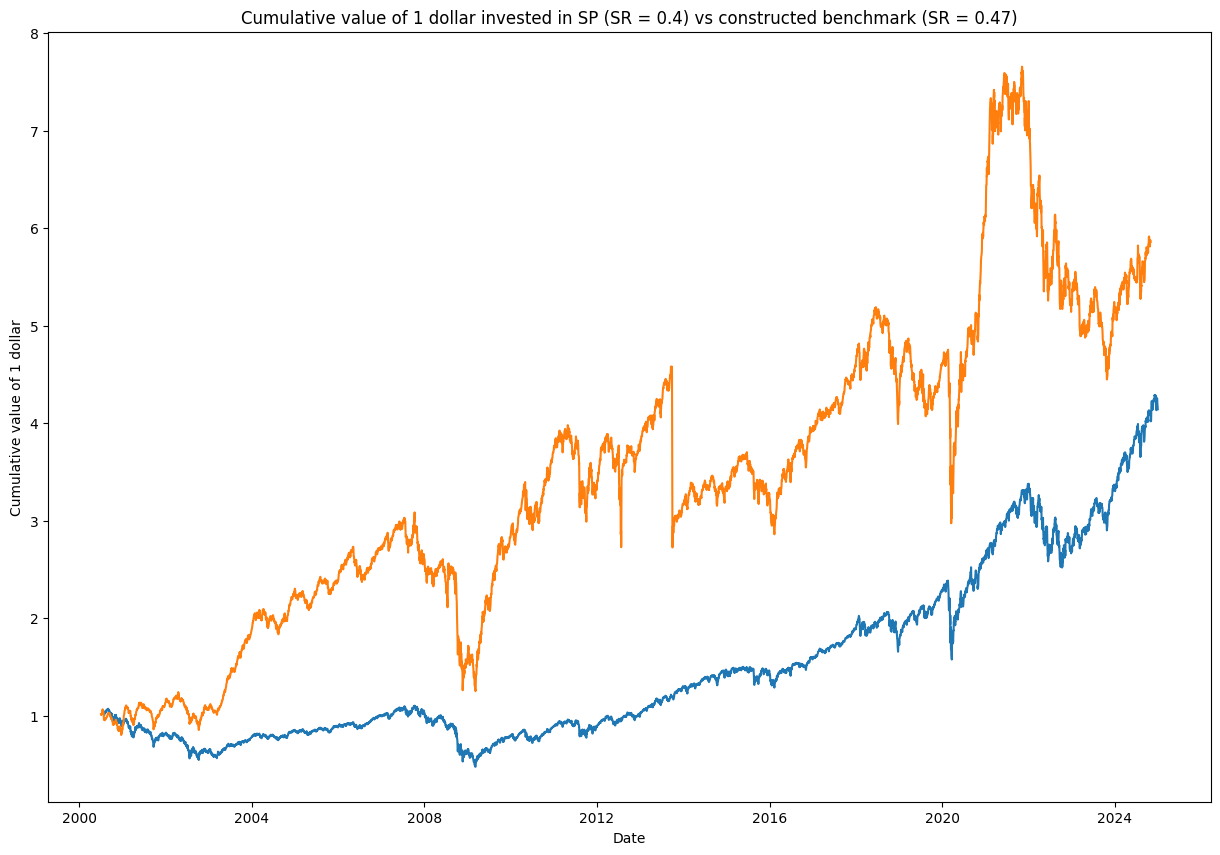

In [22]:
sp500 = dailyret[['date', 'sprtrn']].drop_duplicates("date")
sp500 = sp500[sp500.date >= first_date].reset_index(drop=True)
sp500["cumulative_1dollar"] = (sp500['sprtrn'] + 1).cumprod()

portfolio_returns_df["cumulative_1dollar"] = (portfolio_returns_df['weighted_return'] + 1).cumprod()

sharpe_SP = sharpe_ratio(sp500['sprtrn'])
sharpe_benchmark = sharpe_ratio(portfolio_returns_df["weighted_return"])

fig, ax = plt.subplots(figsize = (15, 10))
sns.lineplot(x = sp500['date'],
             y = sp500['cumulative_1dollar'])
sns.lineplot(x = portfolio_returns_df['date'],
             y = portfolio_returns_df['cumulative_1dollar'])
plt.xlabel("Date")
plt.ylabel(f"Cumulative value of 1 dollar")
plt.title(f"Cumulative value of 1 dollar invested in SP (SR = {sharpe_SP}) vs constructed benchmark (SR = {sharpe_benchmark})")
plt.show()
